In [1]:
library(dplyr)
library(stringr)
library(Seurat) # Seurat v4.1.0
library(ggplot2)
library(RColorBrewer)
library(viridis)
library(ggrepel)
library(reshape2)
library(ggbeeswarm)
library(ggpubr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: SeuratObject

Loading required package: sp

‘SeuratObject’ was built under R 4.3.1 but the current version is
4.3.2; it is recomended that you reinstall ‘SeuratObject’ as the ABI
for R may have changed

‘SeuratObject’ was built with package ‘Matrix’ 1.6.3 but the current
version is 1.6.5; it is recomended that you reinstall ‘SeuratObject’ as
the ABI for ‘Matrix’ may have changed


Attaching package: ‘SeuratObject’


The following object is masked from ‘package:base’:

    intersect


Loading required package: viridisLite



In [2]:
jz.checkgene = function(srat,gene){
    genes = rownames(srat)
    genes[startsWith(genes,gene)]
}

In [3]:
srat = readRDS('../starsolo_output/01_combined_HTO_multiplexed.RDS')
srat

An object of class Seurat 
27507 features across 46980 samples within 2 assays 
Active assay: RNA (27497 features, 0 variable features)
 15 layers present: counts.AG1.1.1, counts.AG3.1.1, counts.AG2.1.1, counts.AQ1.2.1, counts.AQ2.2.1, counts.AQ3.2.1, counts.AQ4.2.1, counts.P1.2, counts.P2.2, counts.P3.2, counts.P4.2, counts.P5.2, counts.P6.2, counts.P7.2, counts.P8.2
 1 other assay present: HTO

In [4]:
srat[["percent.mt"]] <- PercentageFeatureSet(srat, pattern = "^mt-")
srat= subset(srat, subset = nFeature_RNA>300 & percent.mt<25 & HTO_classification.global == 'Singlet') 
srat

An object of class Seurat 
27507 features across 20908 samples within 2 assays 
Active assay: RNA (27497 features, 0 variable features)
 15 layers present: counts.AG1.1.1, counts.AG3.1.1, counts.AG2.1.1, counts.AQ1.2.1, counts.AQ2.2.1, counts.AQ3.2.1, counts.AQ4.2.1, counts.P1.2, counts.P2.2, counts.P3.2, counts.P4.2, counts.P5.2, counts.P6.2, counts.P7.2, counts.P8.2
 1 other assay present: HTO

In [5]:
# remove antigen negative cells P5-P8
srat = subset(srat, subset = orig.ident %in% c('P5','P6','P7','P8'), invert=TRUE)
table(srat$orig.ident)


 AG1  AG2  AG3  AQ1  AQ2  AQ3  AQ4   P1   P2   P3   P4 
  19   28 2818 3413  217 3596 4316 1980 1116   34  404 

In [6]:
srat[['RNA']] = JoinLayers(srat[['RNA']])
srat

An object of class Seurat 
26779 features across 17941 samples within 2 assays 
Active assay: RNA (26769 features, 0 variable features)
 1 layer present: counts
 1 other assay present: HTO

In [7]:
srat$batch = str_sub(srat$orig.ident, 1, -2)

In [8]:
table(srat$batch)


   AG    AQ     P 
 2865 11542  3534 

In [9]:
obj = srat
obj[["RNA"]] <- split(obj[["RNA"]], f = obj$batch)
obj

An object of class Seurat 
26779 features across 17941 samples within 2 assays 
Active assay: RNA (26769 features, 0 variable features)
 3 layers present: counts.AG, counts.AQ, counts.P
 1 other assay present: HTO

In [10]:
obj <- NormalizeData(obj,verbose=FALSE)
obj <- FindVariableFeatures(obj,verbose=FALSE)


In [11]:
obj <- ScaleData(obj,vars.to.regress=c('nFeature_RNA','percent.mt'), verbose=FALSE)
obj <- RunPCA(obj,verbose=FALSE)

In [12]:
obj1 <- IntegrateLayers(object = obj, method = HarmonyIntegration,
                        orig.reduction = "pca", new.reduction = "harmony",verbose = FALSE)


Warning message:
“HarmonyMatrix is deprecated and will be removed in the future from the API in the future”
Warning message:
“Warning: The parameters do_pca and npcs are deprecated. They will be ignored for this function call and please remove parameters do_pca and npcs and pass to harmony cell_embeddings directly.
This warning is displayed once per session.”
Warning message:
“Warning: The parameter tau is deprecated. It will be ignored for this function call and please remove parameter tau in future function calls. Advanced users can set value of parameter tau by using parameter .options and function harmony_options().
This warning is displayed once per session.”
Warning message:
“Warning: The parameter block.size is deprecated. It will be ignored for this function call and please remove parameter block.size in future function calls. Advanced users can set value of parameter block.size by using parameter .options and function harmony_options().
This warning is displayed once per sessi

In [13]:
obj1

An object of class Seurat 
26779 features across 17941 samples within 2 assays 
Active assay: RNA (26769 features, 2000 variable features)
 7 layers present: counts.AG, counts.AQ, counts.P, data.AG, data.AQ, data.P, scale.data
 1 other assay present: HTO
 2 dimensional reductions calculated: pca, harmony

In [14]:
obj1 <- FindNeighbors(obj1, reduction = "harmony", dims = 1:30, verbose=FALSE)
obj1 <- RunUMAP(obj1, reduction = "harmony", dims = 1:30, verbose=FALSE)
obj1 <- FindClusters(obj1, resolution = c(0.1,0.3,0.5), verbose=FALSE)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


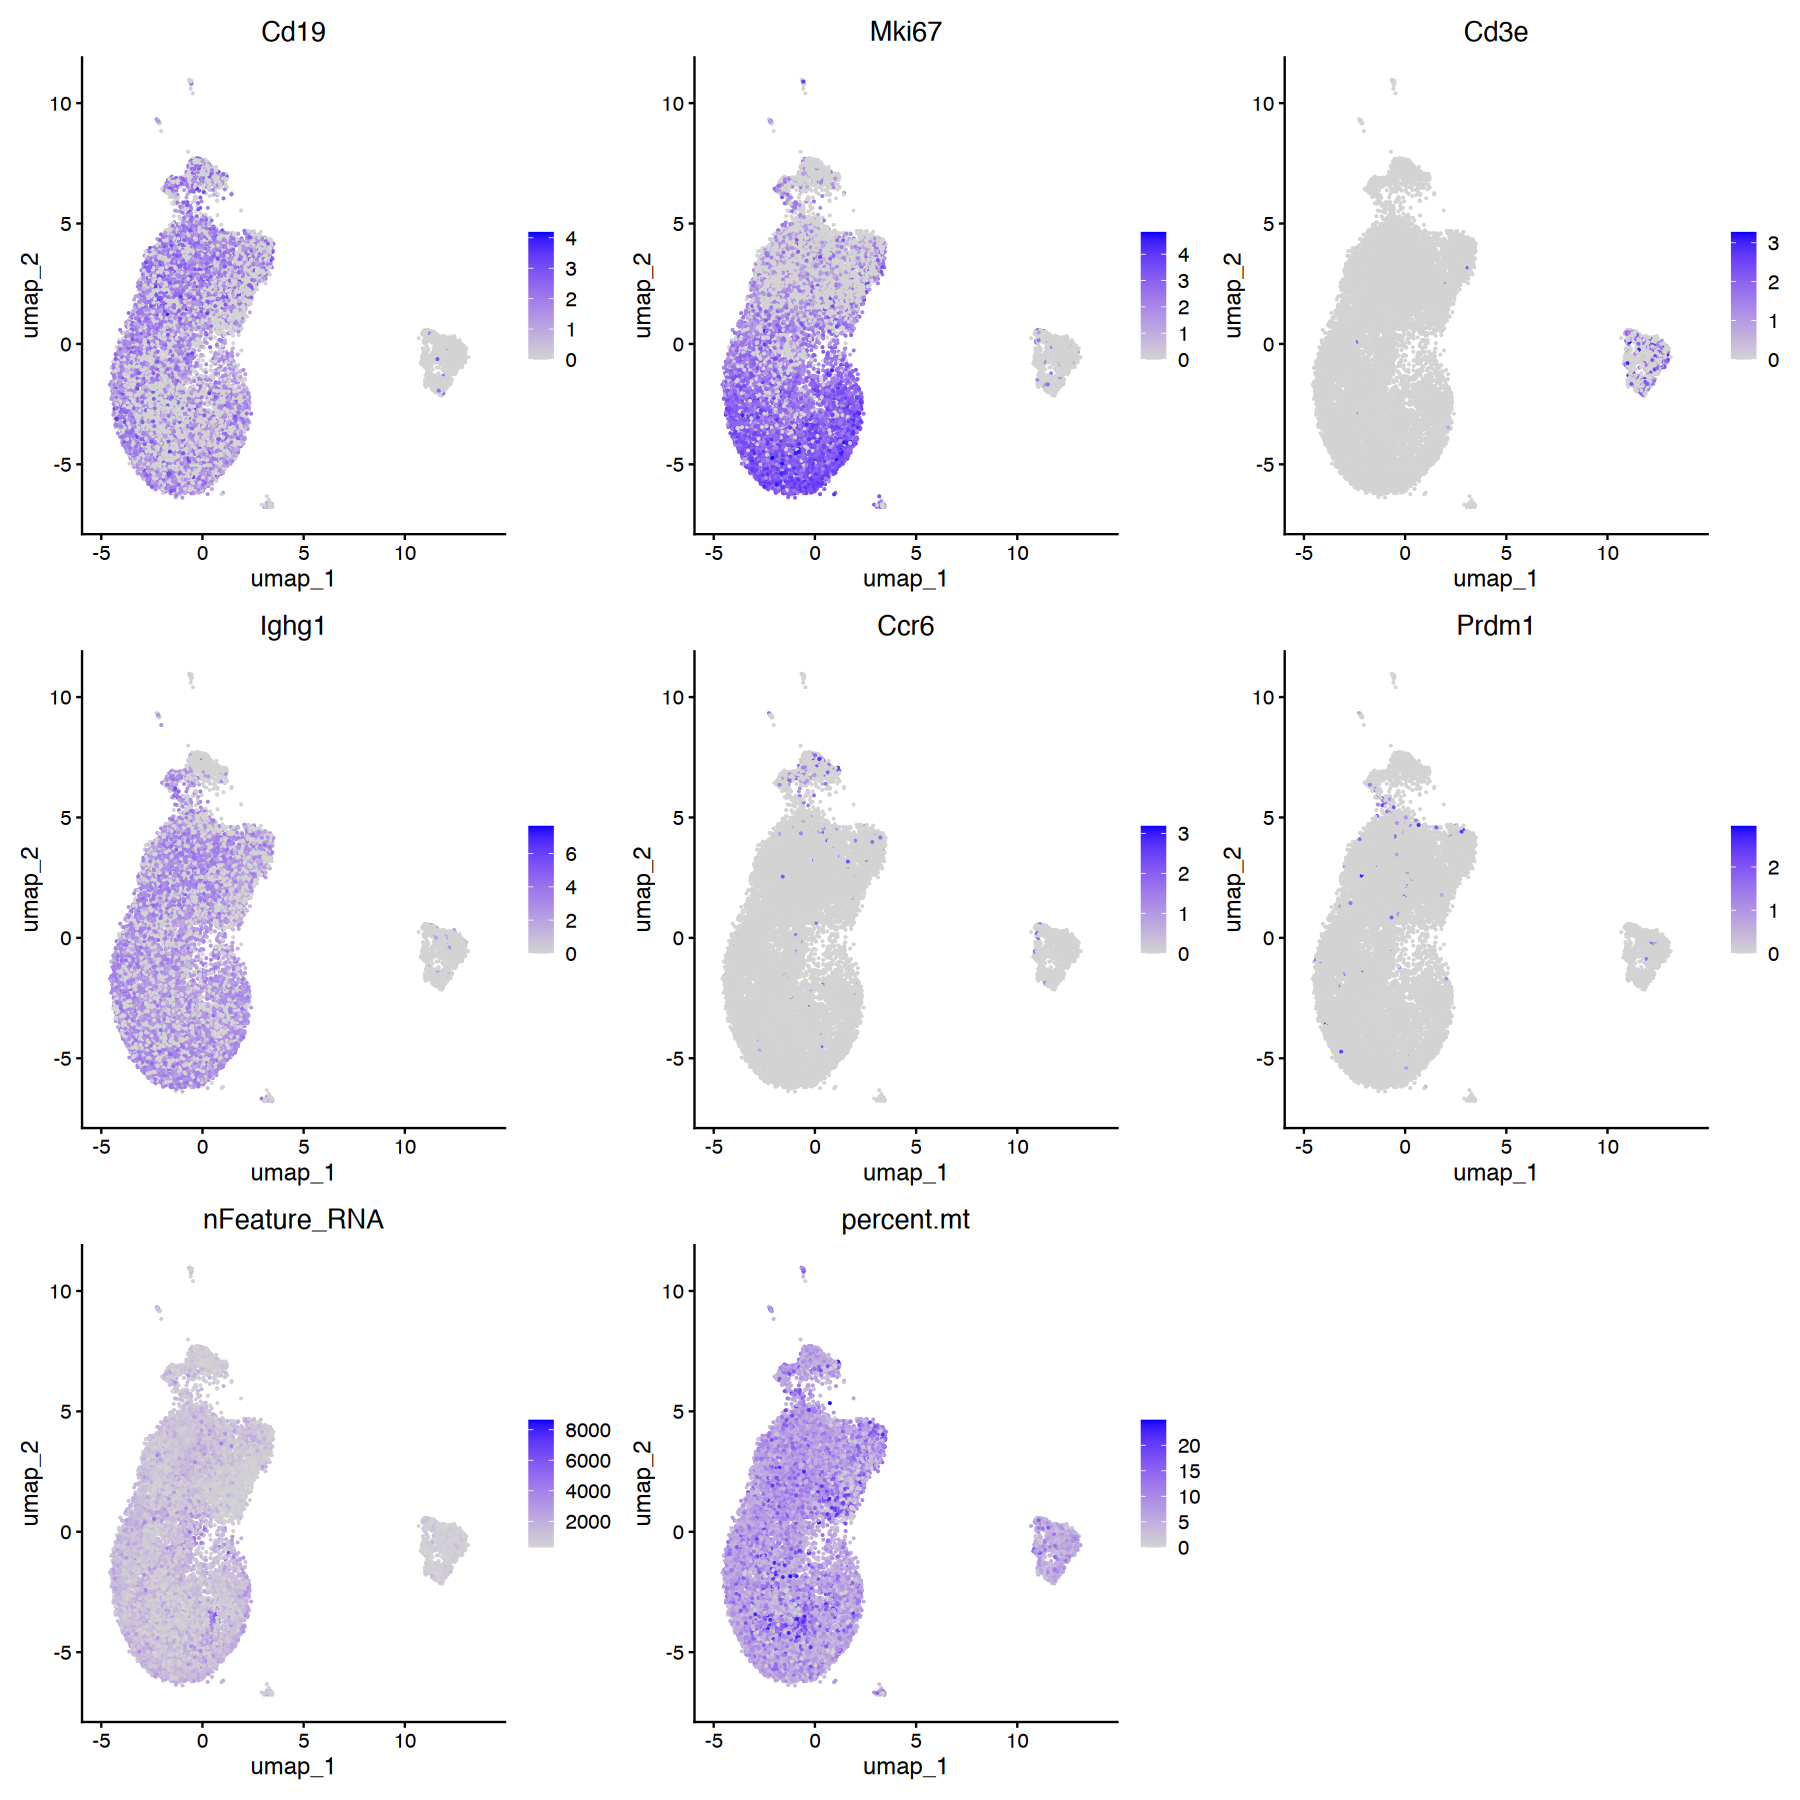

In [15]:
options(repr.plot.width=15, repr.plot.height=15)
FeaturePlot(obj1,c('Cd19','Mki67','Cd3e','Ighg1', 'Ccr6','Prdm1','nFeature_RNA','percent.mt'))

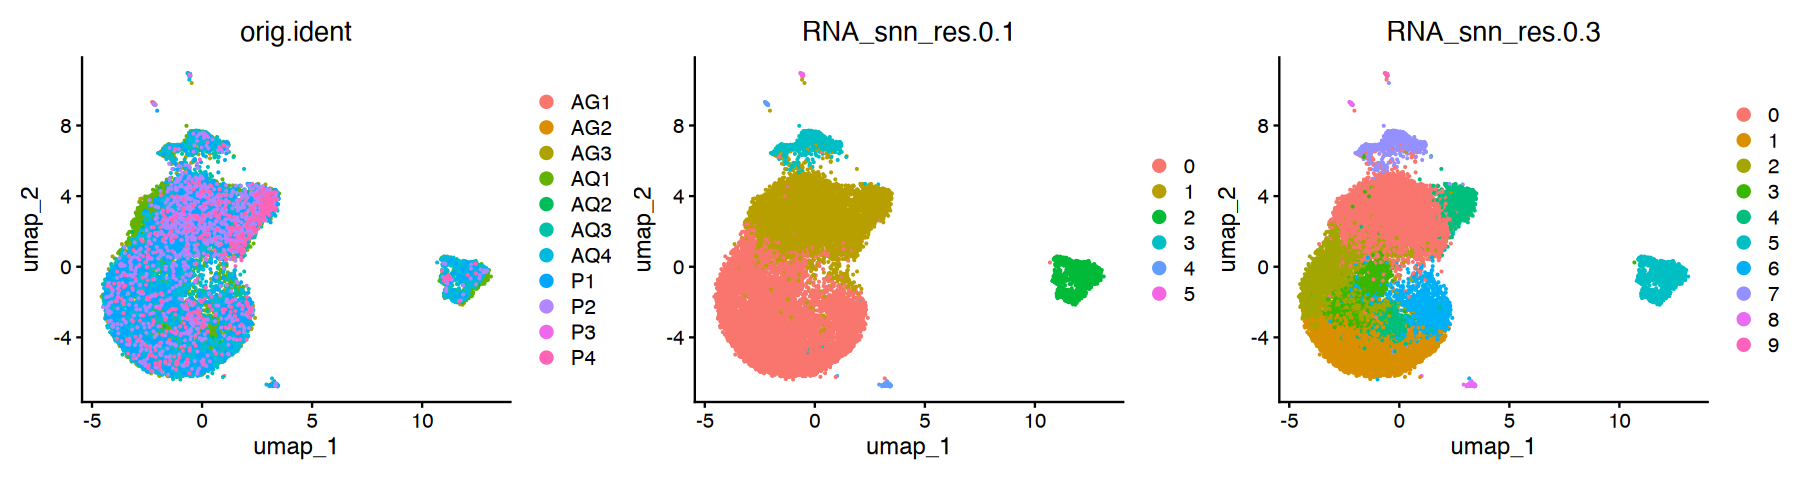

In [16]:
options(repr.plot.width=15, repr.plot.height=4)
DimPlot(obj1, group.by=c('orig.ident','RNA_snn_res.0.1','RNA_snn_res.0.3'))

In [266]:
srat.harmony <- JoinLayers(obj1)
srat.harmony

An object of class Seurat 
26779 features across 20994 samples within 2 assays 
Active assay: RNA (26769 features, 2000 variable features)
 3 layers present: data, counts, scale.data
 1 other assay present: HTO
 3 dimensional reductions calculated: pca, integrated.cca, umap

In [286]:
Idents(srat.harmony) = 'RNA_snn_res.0.1'
df = FindMarkers(srat.harmony,9)
# 5 is pDC, Siglech, Plac8, Bst2, Tyrobp, Ccr9
# 4 is fibroblast. Fgfr2, Lsamp, Lrp1b, Dmd
# 2 is T cells 
#df %>% filter(avg_log2FC>0)  %>% arrange(desc(pct.1-pct.2))%>% head(50)

In [300]:
obj1 = subset(obj1, subset= RNA_snn_res.0.1 %in% c(2, 4, 5), invert = TRUE)
obj1

An object of class Seurat 
26779 features across 19537 samples within 2 assays 
Active assay: RNA (26769 features, 2000 variable features)
 7 layers present: counts.AG, counts.AQ, counts.P, data.AG, data.AQ, data.P, scale.data
 1 other assay present: HTO
 3 dimensional reductions calculated: pca, harmony, umap

In [302]:
obj1 <- ScaleData(obj1,vars.to.regress=c('nFeature_RNA','percent.mt'), verbose=FALSE)
obj1 <- RunPCA(obj1,verbose=FALSE)
obj1 <- IntegrateLayers(object = obj1, method = HarmonyIntegration,
                        orig.reduction = "pca", new.reduction = "harmony",verbose = FALSE)

Warning message:
“HarmonyMatrix is deprecated and will be removed in the future from the API in the future”


In [303]:
obj1 <- FindNeighbors(obj1, reduction = "harmony", dims = 1:30, verbose=FALSE)
obj1 <- RunUMAP(obj1, reduction = "harmony", dims = 1:30, verbose=FALSE)
obj1 <- FindClusters(obj1, resolution = c(0.1,0.3,0.5), verbose=FALSE)

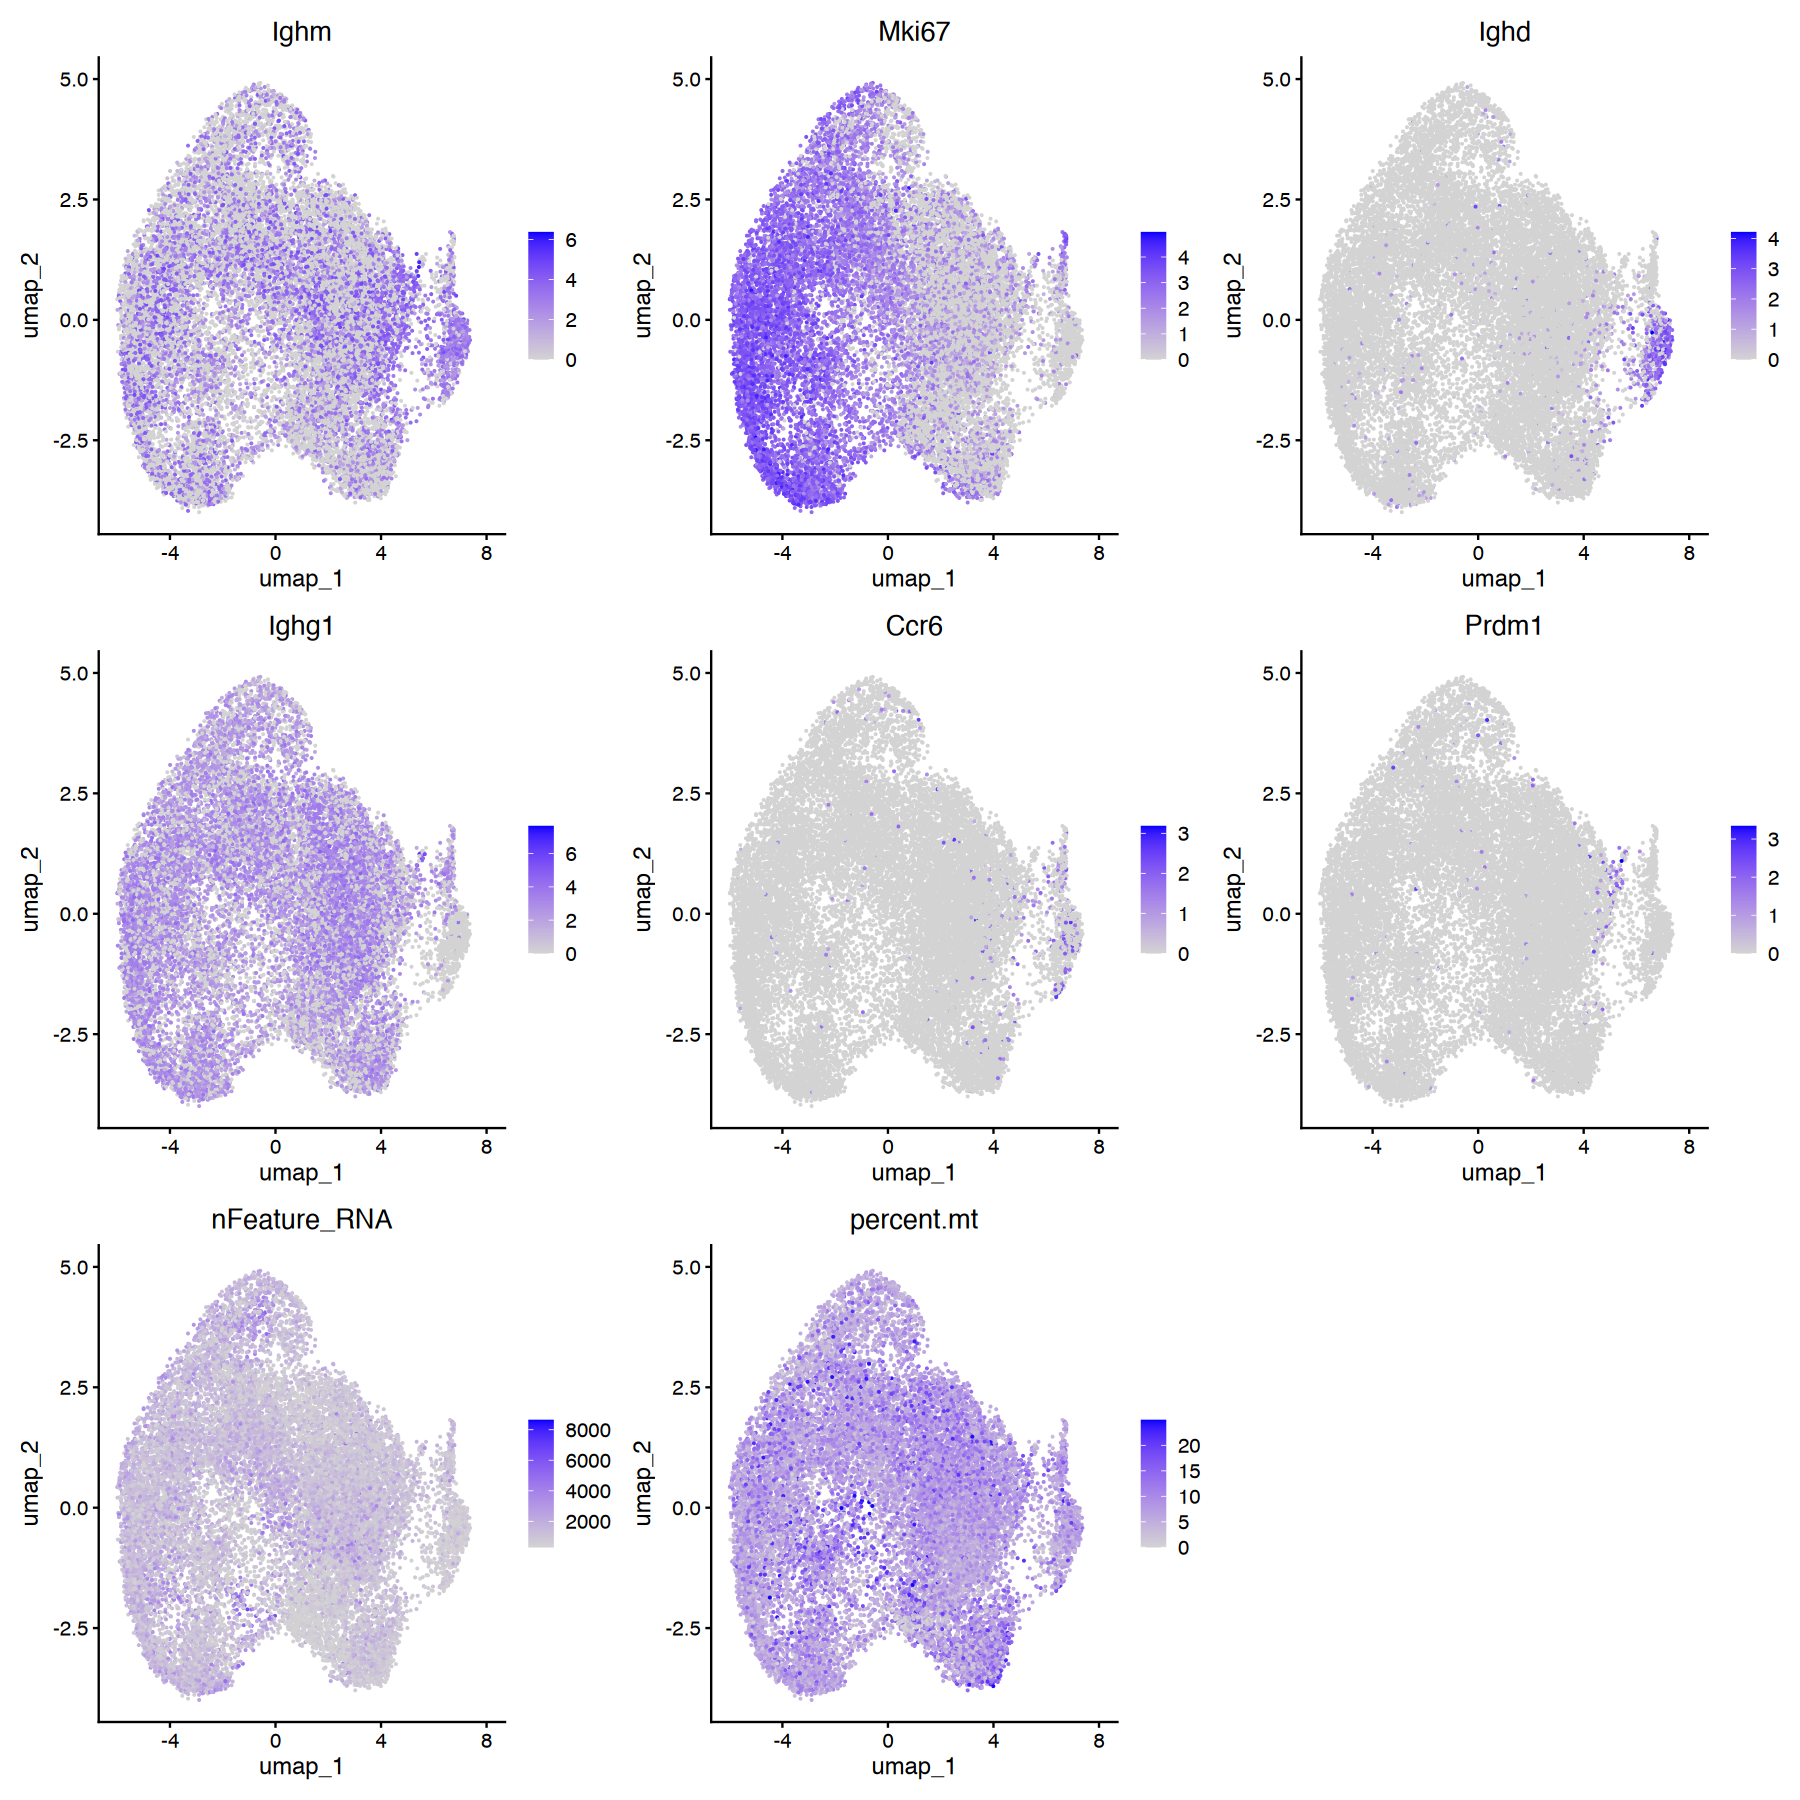

In [310]:
options(repr.plot.width=15, repr.plot.height=15)
FeaturePlot(obj1,c('Ighm','Mki67','Ighd','Ighg1', 'Ccr6','Prdm1','nFeature_RNA','percent.mt'))

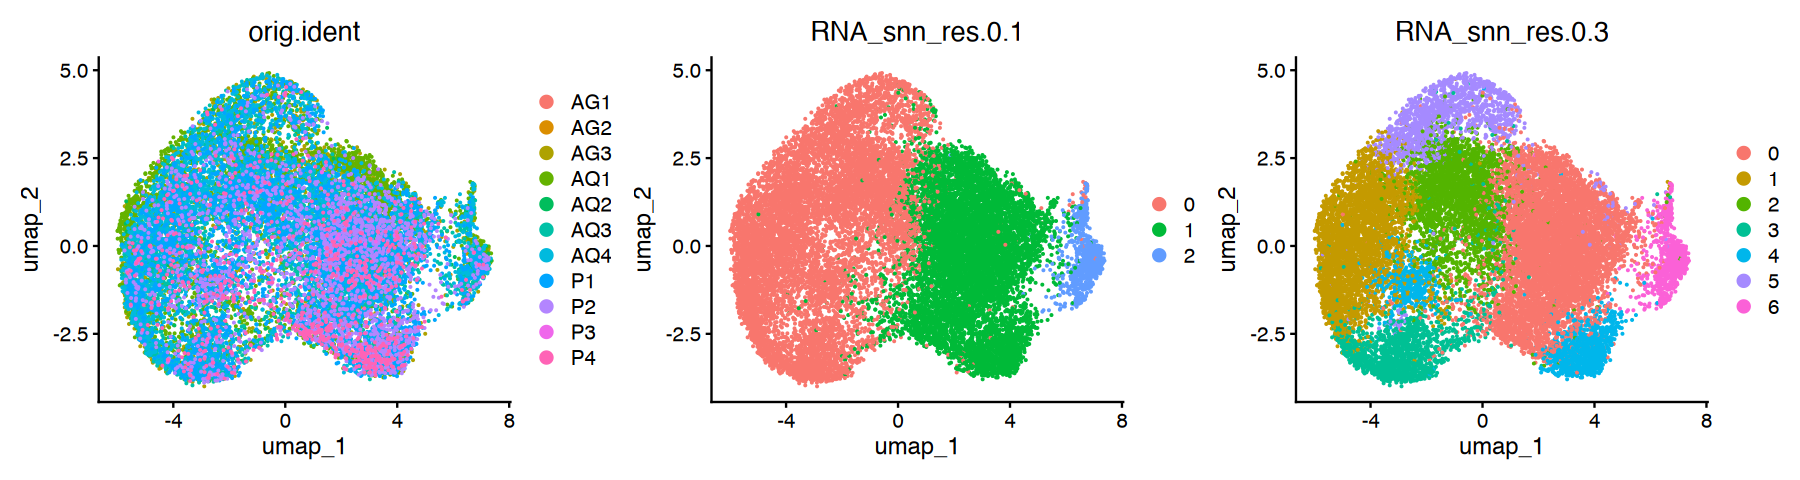

In [305]:
options(repr.plot.width=15, repr.plot.height=4)
DimPlot(obj1, group.by=c('orig.ident','RNA_snn_res.0.1','RNA_snn_res.0.3'))

In [312]:
srat.harmony <- JoinLayers(obj1)
srat.harmony

An object of class Seurat 
26779 features across 19537 samples within 2 assays 
Active assay: RNA (26769 features, 2000 variable features)
 3 layers present: data, counts, scale.data
 1 other assay present: HTO
 3 dimensional reductions calculated: pca, harmony, umap

In [314]:
saveRDS(srat.harmony,'seurat_object/00_harmony_integrated.RDS')